In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

numpy     : 1.21.0
seaborn   : 0.11.1
pandas    : 1.3.0
matplotlib: 3.4.2



In [2]:
from scipy import interpolate

# https://github.com/DaniRuizPerez/PALM-Public-Respository/blob/master/Alignment/getAlignmentsIBD_Taxa.py

#Use B-spline to extrapolate values. NOTE: Parameters s must be adjusted appropriately to avoid over-fitting.
# tck = interpolate.splrep(timepoints, relativeAbundances, k=3, s=0.001, xb=weekFirstSample, xe=weekLastSample)

In [3]:
df_tax_splines = pd.read_csv("../results/tax_clr_splines.csv", index_col=0)

In [4]:
# PARAMETERS
PRESENCE_THRESHOLD = .95
SAMPLING_RATE = 1
OVERLAP_THRESHOLD = .8

max_study_day_no = df_tax_splines.index.max()
min_study_day_no = df_tax_splines.index.min()

a_values = np.arange(0.01, 3.01, .01)
b_values = np.arange(-max_study_day_no, max_study_day_no + .5, .5)

index_splines = np.arange(min_study_day_no, max_study_day_no, SAMPLING_RATE, dtype="int")

In [5]:
def linear_warp(a, b, s):
	return (s - b) / a

In [6]:
lb_linear_constraint = (index_splines.max() - index_splines.min()) * OVERLAP_THRESHOLD

In [7]:
def inv_linear_warp(a, b, s):
	return (a*s) + b

In [8]:
usernames = df_tax_splines["UserName"].unique()

In [9]:
df_tax_counts = pd.read_csv("../data/taxonomy_counts_s_top.txt", index_col=0, sep="\t")
df_mapping = pd.read_csv("../data/SampleID_map.txt", sep='\t', index_col=0)

In [10]:
df_tax_counts = df_tax_counts.T

df_tax_counts.index.name = "#SampleID"

df_tax_counts_username = pd.merge(df_tax_counts, df_mapping.reset_index()[["#SampleID", "UserName"]], on="#SampleID", how="left")

df_tax_counts_username = df_tax_counts_username.set_index("#SampleID")

df_username_presence = df_tax_counts_username.groupby("UserName").apply(lambda x: (x > 0).sum() / x.shape[0])

In [11]:
import pickle
with open("../results/d_splines.pkl", "rb") as inf:
    d_splines = pickle.load(inf)

In [12]:
a = 1.5
b = -5

# usernames
# reference
# PRESENCE_THRESHOLD
# d_splines

def error_a_b_reference(ab, reference, current, presence_threshold, d_splines, overlap_threshold):
    a = ab[0]
    b = ab[1]
    reference_inv_warp = inv_linear_warp(a, b, index_splines)

    # alpha is the max(reference_sample, inv_linear_warp(current_sample))
    # beta is the min(reference_sample_t, inv_linear_warp(current_sample))
    alpha = max(index_splines.min(), reference_inv_warp.min())
    beta = min(index_splines.max(), reference_inv_warp.max())

    overlap =  (beta - alpha) / (index_splines.max() - index_splines.min())

#     if overlap > overlap_threshold and alpha < beta:
    error = get_alignment_error(a, b, alpha, beta, index_splines, reference, current, presence_threshold, d_splines)
#     else:
#         error = get_alignment_error(1, 0, index_splines.min(), index_splines.max(), index_splines, reference, usernames, presence_threshold, d_splines)
    return error

In [13]:
# def get_alignment_error(a, b, alpha, beta, index_splines, reference, current, presence_threshold, d_splines):
#     current_warp = linear_warp(a, b, index_splines)
#     reference_taxonomies = set(df_username_presence.loc[reference, df_username_presence.loc[reference, :] > PRESENCE_THRESHOLD].index)

#     current_taxonomies = set(df_username_presence.loc[current, df_username_presence.loc[current, :] > PRESENCE_THRESHOLD].index)
#     filtered_taxonomies = reference_taxonomies.intersection(current_taxonomies)
    
#     error_tax = np.repeat(0.0, len(filtered_taxonomies))
    
#     for ix_tax, taxonomy in enumerate(filtered_taxonomies):
#         spline_reference, reference_min, reference_max = d_splines[reference][taxonomy]
#         spline_current, current_min, current_max = d_splines[current][taxonomy]
#         ts_current = interpolate.splev(index_splines, spline_current)
#         ts_current = np.clip(ts_current_warp, current_min, current_max)
        
#         spline = interpolate.splrep(current_warp, values, k=3, xb=min_subj_study_day_no, xe=max_subj_study_day_no)

        
#         spline_values = interpolate.splev(spline_timepoints, spline)
        

#         ts_reference = interpolate.splev(index_splines, spline_reference)
#         ts_current_warp = interpolate.splev(current_warp, spline_current)

#         ts_reference = np.clip(ts_reference, reference_min, reference_max)
#         ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

#         cur_error = np.linalg.norm(ts_reference - ts_current_warp)
#         cur_error = cur_error / (beta - alpha)
#         error_tax[ix_tax] = cur_error
#     return np.mean(error_tax)

In [14]:
def get_alignment_error(a, b, alpha, beta, index_splines, reference, current, presence_threshold, d_splines):
    current_warp = linear_warp(a, b, index_splines)
    reference_taxonomies = set(df_username_presence.loc[reference, df_username_presence.loc[reference, :] > PRESENCE_THRESHOLD].index)

    current_taxonomies = set(df_username_presence.loc[current, df_username_presence.loc[current, :] > PRESENCE_THRESHOLD].index)
    filtered_taxonomies = reference_taxonomies.intersection(current_taxonomies)
    
    error_tax = np.repeat(0.0, len(filtered_taxonomies))
    
    for ix_tax, taxonomy in enumerate(filtered_taxonomies):
        spline_reference, reference_min, reference_max = d_splines[reference][taxonomy]
        spline_current, current_min, current_max = d_splines[current][taxonomy]

        ts_reference = interpolate.splev(index_splines, spline_reference)
        ts_current_warp = interpolate.splev(current_warp, spline_current)

        ts_reference = np.clip(ts_reference, reference_min, reference_max)
        ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

        cur_error = np.linalg.norm(ts_reference - ts_current_warp)
        cur_error = cur_error / (beta - alpha)
        error_tax[ix_tax] = cur_error
    return np.mean(error_tax)

In [15]:
from scipy.optimize import minimize

In [16]:
def gen_constraint_overlap(index_splines):
    def inner_constraint(ab):
        a = ab[0]
        b = ab[1]
        reference_inv_warp = inv_linear_warp(a, b, index_splines)

        # alpha is the max(reference_sample, inv_linear_warp(current_sample))
        # beta is the min(reference_sample_t, inv_linear_warp(current_sample))
        alpha = max(index_splines.min(), reference_inv_warp.min())
        beta = min(index_splines.max(), reference_inv_warp.max())

        overlap =  (beta - alpha) / (index_splines.max() - index_splines.min())
        return overlap
    return inner_constraint
    
def gen_constraint_greater_than(index_splines):
    def inner_constraint(ab):
        a = ab[0]
        b = ab[1]
        reference_inv_warp = inv_linear_warp(a, b, index_splines)
#         reference_inv_warp = linear_warp(a, b, index_splines)

        # alpha is the max(reference_sample, inv_linear_warp(current_sample))
        # beta is the min(reference_sample_t, inv_linear_warp(current_sample))
        alpha = max(index_splines.min(), reference_inv_warp.min())
        beta = min(index_splines.max(), reference_inv_warp.max())

        return beta - alpha
    return inner_constraint

In [17]:
import itertools

In [18]:
bounds = [(0.01, 3), (-15, 15)]

from scipy.optimize import NonlinearConstraint, LinearConstraint

constraint_overlap = NonlinearConstraint(gen_constraint_overlap(index_splines), lb=OVERLAP_THRESHOLD, ub=np.inf)
constraint_gt = NonlinearConstraint(gen_constraint_greater_than(index_splines), lb=0, ub=np.inf)
constraint_cobyla_a = LinearConstraint((1,0), lb=0.01, ub=3)
constraint_cobyla_b = LinearConstraint((0,1), lb=-15, ub=15)

# reference = usernames[0]

results = []

for (reference, current) in itertools.product(usernames, usernames):
    res = minimize(
        error_a_b_reference,
    #     method="COBYLA",
        x0=[1, 0.0],
        args=(reference, current, PRESENCE_THRESHOLD, d_splines, OVERLAP_THRESHOLD),
        constraints=(constraint_overlap, constraint_gt, constraint_cobyla_a, constraint_cobyla_b),
    #     bounds=bounds,
    )
    if not res.success:
            res = minimize(
                    error_a_b_reference,
                    method="COBYLA",
                    x0=[1, 0.0],
                    args=(reference, current, PRESENCE_THRESHOLD, d_splines, OVERLAP_THRESHOLD),
                    constraints=(constraint_overlap, constraint_gt, constraint_cobyla_a, constraint_cobyla_b),
                #     bounds=bounds,
            )
    results.append((reference, current, res))

In [19]:
res = minimize(
    error_a_b_reference,
    method="COBYLA",
    x0=[1, 0.0],
    args=("MCTs01", "MCTs01", PRESENCE_THRESHOLD, d_splines, OVERLAP_THRESHOLD),
    constraints=(constraint_overlap, constraint_gt, constraint_cobyla_a, constraint_cobyla_b),
#     bounds=bounds,
)

In [20]:
mat = []
cols = ["reference", "current", "error", "a", "b"]
for result in results:
    res = result[2]
    mat.append([result[0], result[1], res.fun, res.x[0], res.x[1]])

df_alignment_results = pd.DataFrame(mat, columns=cols)

In [21]:
df_alignment_error = df_alignment_results.pivot(index="reference", columns="current", values="error").copy()

In [22]:
df_alignment_error.values[[np.arange(df_alignment_error.shape[0])]*2] = 0

/tmp/ipykernel_2594403/4059380397.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_alignment_error.values[[np.arange(df_alignment_error.shape[0])]*2] = 0


In [23]:
best_aligner = df_alignment_error.mean(axis=1).sort_values().index[0]

In [24]:
best_aligner

'MCTs07'

In [25]:
df_alignment_results.query(f"reference == '{best_aligner}'")

,reference,current,error,a,b
160,MCTs07,MCTs01,0.325505,1.000000,-5.134722e-09
161,MCTs07,MCTs03,0.368672,1.000000,-3.295947e-12
162,MCTs07,MCTs04,0.430172,1.671879,-6.719327e-01
163,MCTs07,MCTs05,0.632598,1.000000,-7.627105e-12
164,MCTs07,MCTs06,0.272421,3.000000,-1.368676e+01
165,MCTs07,MCTs07,0.000160,1.000099,1.116783e-05
166,MCTs07,MCTs08,0.565270,1.061869,-6.189459e-02
167,MCTs07,MCTs09,0.268159,1.000000,-2.061625e-08
168,MCTs07,MCTs10,0.298235,1.000000,-2.286464e-08
169,MCTs07,MCTs13,0.357914,1.000000,-2.199805e-08


In [26]:
current = "MCTs36"
reference = best_aligner
species = 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium longum'

d_splines[current]['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium longum']

((array([ 1.,  1.,  1.,  1.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
         12., 13., 14., 15., 17., 17., 17., 17.]),
  array([ 0.11546536, -3.36959754,  2.76369352, -1.03152749, -0.94750249,
          1.44637399, -1.83584865,  2.21993791, -2.30788091, -0.34357979,
          0.21176478,  0.48454893,  0.4571884 , -0.79667789,  4.6935093 ,
         -1.08155162,  1.57320832,  0.        ,  0.        ,  0.        ,
          0.        ]),
  3),
 -3.0479657016183626,
 4.043878248171611)

In [27]:
# sampling_rate = np.arange(warped_time.min(), warped_time.max(), SAMPLING_RATE)

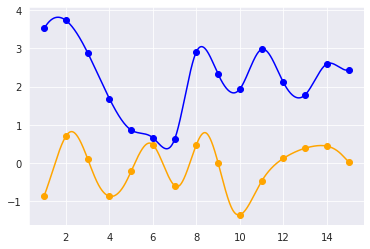

In [28]:
current = "MCTs36"
reference = best_aligner
taxonomy = 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium longum'

# for row in df_alignment_results.query(f"reference == '{best_aligner}'").iterrrows():

row = df_alignment_results.query(f"reference == '{reference}' & current == '{current}'")

spline_reference, reference_min, reference_max = d_splines[reference][taxonomy]
spline_current, current_min, current_max = d_splines[current][taxonomy]

index_smooth_current = np.linspace(index_splines.min(), index_splines.max(), 10_000)
current_smooth_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_smooth_current)

ts_reference_smooth_warp = interpolate.splev(index_smooth_current, spline_reference)
ts_current_smooth_warp = interpolate.splev(current_smooth_warp, spline_current)

ts_reference_smooth_warp = np.clip(ts_reference_smooth_warp, reference_min, reference_max)
ts_current_smooth_warp = np.clip(ts_current_smooth_warp, current_min, current_max)

current_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

# index_warp_arange = np.arange(np.ceil(current_warp.min()), np.floor(current_warp.max()), dtype=int)

# current_warp = inv_linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

ts_reference = interpolate.splev(index_splines, spline_reference)
ts_current_warp = interpolate.splev(current_warp, spline_current)

ts_reference = np.clip(ts_reference, reference_min, reference_max)
ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

fig, ax = plt.subplots()

plt.plot(index_smooth_current, ts_reference_smooth_warp, color="blue")
plt.plot(index_smooth_current, ts_current_smooth_warp, color="orange")

plt.plot(index_splines, ts_reference, 'o', color="blue")
plt.plot(index_splines, ts_current_warp, 'o', color="orange")

# plt.plot(index_splines, reference_max, 'ob')
plt.show()

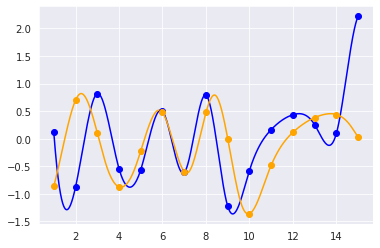

In [29]:
current = "MCTs36"
reference = best_aligner
taxonomy = 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium longum'

# for row in df_alignment_results.query(f"reference == '{best_aligner}'").iterrrows():

row = df_alignment_results.query(f"reference == '{reference}' & current == '{current}'")

spline_reference, reference_min, reference_max = d_splines[current][taxonomy]
spline_current, current_min, current_max = d_splines[current][taxonomy]

index_smooth_current = np.linspace(index_splines.min(), index_splines.max(), 10_000)
current_smooth_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_smooth_current)

ts_reference_smooth_warp = interpolate.splev(index_smooth_current, spline_reference)
ts_current_smooth_warp = interpolate.splev(current_smooth_warp, spline_current)

ts_reference_smooth_warp = np.clip(ts_reference_smooth_warp, reference_min, reference_max)
ts_current_smooth_warp = np.clip(ts_current_smooth_warp, current_min, current_max)

current_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

index_warp_arange = np.arange(np.ceil(current_warp.min()), np.floor(current_warp.max()), dtype=int)

# current_warp = inv_linear_warp(row['a'].values[0], row['b'].values[0], index_warp_arange)

ts_reference = interpolate.splev(index_splines, spline_reference)
ts_current_warp = interpolate.splev(current_warp, spline_current)

ts_reference = np.clip(ts_reference, reference_min, reference_max)
ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

fig, ax = plt.subplots()

plt.plot(index_smooth_current, ts_reference_smooth_warp, color="blue")
plt.plot(index_smooth_current, ts_current_smooth_warp, color="orange")

plt.plot(index_splines, ts_reference, 'o', color="blue")
plt.plot(index_splines, ts_current_warp, 'o', color="orange")

# plt.plot(index_splines, reference_max, 'ob')
plt.show()

In [30]:
inv_linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

array([-0.24926635,  0.98959521,  2.22845677,  3.46731833,  4.7061799 ,
        5.94504146,  7.18390302,  8.42276458,  9.66162614, 10.9004877 ,
       12.13934927, 13.37821083, 14.61707239, 15.85593395, 17.09479551])

In [31]:
index_realtime = linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

In [32]:
inv_linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

array([-0.24926635,  0.98959521,  2.22845677,  3.46731833,  4.7061799 ,
        5.94504146,  7.18390302,  8.42276458,  9.66162614, 10.9004877 ,
       12.13934927, 13.37821083, 14.61707239, 15.85593395, 17.09479551])

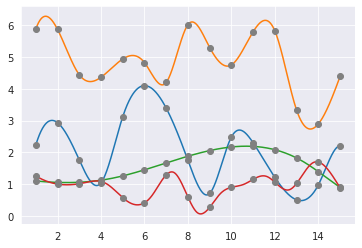

In [33]:
current = "MCTs36"
reference = best_aligner
taxonomy = 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium longum'

username_with_tax = set(df_username_presence.loc[df_username_presence.loc[:, taxonomy] > PRESENCE_THRESHOLD].index)

fig, ax = plt.subplots()

ix = 0
for name, row in df_alignment_results.query(f"reference == '{best_aligner}'").iterrows():
    current = row['current']
    if current in username_with_tax and reference != current:
        spline_current, current_min, current_max = d_splines[current][taxonomy]
        
        index_smooth_current = np.linspace(index_splines.min(), index_splines.max(), 10_000)
        current_smooth_warp = linear_warp(row['a'], row['b'], index_smooth_current)

        ts_current_smooth_warp = interpolate.splev(current_smooth_warp, spline_current)
        ts_current_smooth_warp = np.clip(ts_current_smooth_warp, current_min, current_max)
        
        
        current_warp = linear_warp(row['a'], row['b'], index_splines)

        ts_current_warp = interpolate.splev(current_warp, spline_current)
        ts_current_warp = np.clip(ts_current_warp, current_min, current_max)
        
        plt.plot(index_smooth_current, ts_current_smooth_warp)
        plt.plot(index_splines, ts_current_warp, 'o', color='grey')
        ix += 1
    if ix > 3:
        break

# plt.plot(index_splines, reference_max, 'ob')
plt.show()

In [34]:
df_alignment_results.to_csv("../results/alignment_results.txt", sep="\t", index=False)

In [35]:
# 			T = [warpFunction(a, b, timepointReferenceSample.offsetID) for timepointReferenceSample in timepointsListReferenceSample]
# ##			T_inverse = [warpFunctionInverse(a, b, timepointCurrentSample.offsetID) for timepointCurrentSample in timepointsListCurrentSample]
# 			timepointCurrentSampleMin = warpFunctionInverse(a, b, min(CurrentSampleT))
# 			timepointCurrentSampleMax = warpFunctionInverse(a, b, max(CurrentSampleT))
# 			alpha = max(timepointReferenceSampleMin, timepointCurrentSampleMin)
# 			beta = min(timepointReferenceSampleMax, timepointCurrentSampleMax)
# 			overlap =  (beta - alpha) / (timepointReferenceSampleMax - timepointReferenceSampleMin)
# 			if overlap > OVERLAP_THRESHOLD and alpha < beta:
# 				[alignmentError, a, b] = getAlignmnetError(a, b, alpha, beta, timepointsListReferenceSample, timepointsListCurrentSample, taxonWeights, useSplines)
# 				if len(optimalAlignmentParameters) == 0 or optimalAlignmentParameters[0] > alignmentError:
# 					optimalAlignmentParameters = [alignmentError, a, b, alpha, beta, overlap]